<a href="https://colab.research.google.com/github/kdv4/Fake_News_Detection/blob/main/Train_ISOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection using hybrid CNN and RNN approach
For ISOT Dataset<br><br>
@author: <br> Kishan Vaishnani <br> Dhyanil Mehta


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Useful libraries

In [ ]:
import pandas as pd
import re
import os 
import keras
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model

## Hyperparameter

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [ ]:
data_fake=pd.read_csv("/content/drive/Shareddrives/PRML_Fake News/News_dataset/Fake.csv")
data_true=pd.read_csv("/content/drive/Shareddrives/PRML_Fake News/News_dataset/True.csv")

In [ ]:
data_fake.head()
data_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Preprocess Dataset:
- Extracting tile and text field from the datset to train our network.
- Combining this 2 column to make larger dataset to train
- Tokenize this data using keras tokenizer 

In [ ]:
texts = []
labels = []

for i in range(data_true.title.shape[0]):
    text1 = data_true.title[i]
    text2 = data_true.text[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(1)

for i in range(data_fake.title.shape[0]):
    text1 = data_fake.title[i]
    text2 = data_fake.text[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(0)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 166697 unique tokens.


In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# labels = to_categorical(np.asarray(labels),num_classes = 2)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (44898, 1000)
Shape of label tensor: (44898,)


Train test data split

In [ ]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50)

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU

%matplotlib inline

## Word Embedding
We have used pre trained glove model to convert token into eord vector

In [ ]:
#Using Pre-trained word embeddings
GLOVE_DIR = "/content/drive/Shareddrives/PRML_Fake News/glove" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Total 400000 word vectors in Glove.


# CNN & LSTM Model to be train

In [ ]:
EPOCHS = 10
modell = Sequential()
modell.add(embedding_layer)
# modell.add(Dropout(0.2))
modell.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(100,D))
modell.add(BatchNormalization())
modell.add(Dense(256, activation='relu'))
modell.add(Dense(128, activation='relu'))
modell.add(Dense(64, activation='relu'))
modell.add(Dense(1, activation='sigmoid'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modell.summary())
history=modell.fit(x_train, y_train, epochs=EPOCHS, batch_size=64,validation_data=(x_val,y_val))

modell.save('lstm_ISOT.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         16669800  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1000, 32)          16032     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 500, 64)           6208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)              

## Print training graph

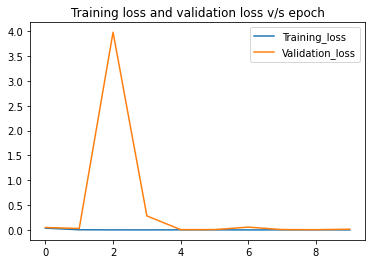

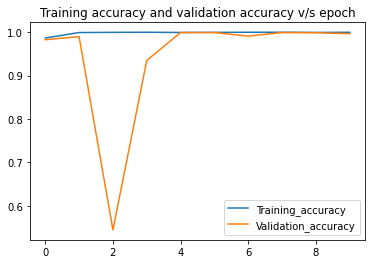

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(range(EPOCHS),history.history['loss'])
plt.plot(range(EPOCHS),history.history['val_loss'])
plt.title("Training loss and validation loss v/s epoch")
plt.legend(["Training_loss","Validation_loss"])
plt.savefig("Training loss and validation loss.jpg")
plt.show()

plt.figure()
plt.plot(range(EPOCHS),history.history['accuracy'])
plt.plot(range(EPOCHS),history.history['val_accuracy'])
plt.title("Training accuracy and validation accuracy v/s epoch")
plt.legend(["Training_accuracy","Validation_accuracy"])
plt.savefig("Training accuracy and validation accuracy.jpg")
plt.show()